In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import cvxpy as cp
from numpy import linalg as LA
import pprint
from lap import lapjv
import copy
import sys
import datetime
from tqdm import tqdm_notebook

ro = np.linspace(0,1,20)

n= 50

k = 10

a = 0.3

num_loop = 1000


In [2]:
# Construct K
def K_Bernoulli(n,a):
    np.random.seed(3)
    K=np.identity(n)
    P=np.ones([n,n]) 
    K = P-K
    #print(K)
    for i in range(n):
        for j in range(i+1,n):
            K[i][j] = round(random.uniform(a,1-a),2)
            #K[i][j] = random.uniform(alpha,1-alpha)
            K[j][i]=K[i][j]        
    return K
     

# Generate A
def A_adj(K):
    n = len(K)
    B=np.identity(len(K))
    P=np.ones([n,n]) 
    #print(P)
    B= P-B
    #print(B)
    for i in range(len(B)):
        for j in range(i+1,len(B)):
            B[i][j] =random.uniform(0,1)
            if B[i][j] < K[i][j]:
                B[i][j] = 1
            else:
                B[i][j] = 0
            B[j][i] = B[i][j]
    A = B
    return A

# Generate B
def B_adj(ro,K,A):
    B = np.zeros([len(A),len(A)])
    for i in range(len(B)):
        for j in range(i+1,len(B)):
            B[i][j] =random.uniform(0,1)
            if B[i][j] < (1-ro)*K[i][j] + ro*A[i][j]:
                B[i][j] = 1
            else:
                B[i][j] = 0
            B[j][i] = B[i][j]
    return B
    
    
                
            
                
            


In [3]:
#Construct a n-degree permutation matrix 

def permu(N):
    E=np.identity(N)
    permutation = np.random.permutation(N)
    P=np.zeros([N,N]) #initialize the permutation matrix
     
    for i in range(0,N):
        P[i]=E[permutation[i]]
    
    
    return P.astype(int)


In [4]:
# Generate a random aj matrix for unweighted and undirected graph
def generate_aj_matrix(n):
    id = np.identity(n)
    ones_mat=np.ones((n, n)) 
    arr = ones_mat - id
    #print(arr)
    for i in range(n):
        for j in range(i+1,n):
            arr[i][j] = random.choice([0,1])
            arr[j][i] = arr[i][j]
    return arr

In [5]:
def ret_permu_result(l,n):
    ret = np.zeros((n, n))
    for i in range(n):
        ret[i][l[i]] = 1
    #print(ret)
    return ret

In [6]:
def f_for_step_3(A,B,P):
    return -np.trace(A@P@B.T@P.T)

In [7]:
def get_alpha_value(A,B,P,Q):
    alpha = 0
    a = -np.trace(A@P@B.T@P.T-A@P@B.T@Q.T-A@Q@B.T@P.T+A@Q@B.T@Q.T)
    b  = np.trace(2*(A@P@B.T@P.T)-A@P@B.T@Q.T-A@Q@B.T@P.T)
    x_extreme = -b/(2*a)
    dic = dict()
    dic[0] = f_for_step_3(A,B,P)
    dic[1]=f_for_step_3(A,B,Q)
    dic[x_extreme] = f_for_step_3(A,B,(1-x_extreme)*P+x_extreme*Q)
    
    #print(dic)
    if (x_extreme < 1) and (x_extreme>0):    
        Min = dic[0]
        key = 0
        for k, v in dic.items():
            if v < Min:
                #print(key, Min)
                #print(k,v)
                #print(v < Min)
                key = k
                Min = v
        #print(key)
        return key
    else:
        
        Min = dic[0]
        if dic[1]<Min:
            Min = dic[1]
            #print(1)
            return 1
        #print(0)
        return 0 
        

    

In [8]:
def loss_P_1_percent(P_D_r,P_1):
    loss = 0
    for i in (P_D_r==P_1):
        for j in i:
            if j == False:
                loss +=1
    loss = loss/2
    loss_percent = loss/n
    return loss_percent

In [9]:
def FAQ(n,A,B,initial,eps,loop,num_loop):
    loop += 1
    # Compute gradient
    gradient = -A@initial@B.T - A.T@initial@B
        
    # Dropping terms independent of P
    x,y,c = lapjv(gradient)
    index_list = y
    Q = ret_permu_result(index_list,n)
    
    
    # Update P
    alpha = get_alpha_value(A,B,initial,Q)
    P_new = (1-alpha)*initial + alpha*Q
    #P_new = initial + alpha*Q
    
    
    if loop>num_loop:
        # Projection
        e,r,t = lapjv(-P_new.T)
        #print(r)
        P_result = ret_permu_result(r,n).T
        #print("out of time",P_result)
        return P_result

    if LA.norm(P_new-initial, 'fro') < eps:
        # Projection
        e,r,t = lapjv(-P_new.T)
        #print(r)
        P_result = ret_permu_result(r,n).T
        #print("norm close\n",P_result)
        return P_result
    else:
        return FAQ(n,A,B,P_new,eps,loop,num_loop) 
    #print(P_new)

In [10]:


def Projection_D_cvx(A,B,n,P_1):
    starttime = datetime.datetime.now()
    
    P = cp.Variable((n,n))
    arr = cp.expressions.constants.Constant([[1 for i in range(n)]])
    constraints = [P.__matmul__(arr) == arr, P.T.__matmul__(arr) == arr, cp.min(P)>=0]
    prob = cp.Problem(cp.Minimize((cp.norm(P.__matmul__(B)-(P.T.__matmul__(A.T)).T, 'fro'))**2), constraints)
    # prob = cp.Problem(cp.Minimize(LA.norm(np.multiply(P,A)-np.matmul(B,P), 'fro')), constraints)
    prob.solve()
    
    
    P_step_1 = copy.deepcopy(P.value)

    # Projection
    e,r,t = lapjv(-P_step_1)
    #print(r)
    P_D_r = ret_permu_result(r,n)
    
    loss = 0
    for i in (P_D_r==P_1):
        for j in i:
            if j == False:
                loss +=1
    loss = loss/2
    loss_percent = loss/n
    align_percent = 1- loss_percent
    #print(loss_percent)
    
    original_error = LA.norm(A@P_1 - P_1@B,"fro")
    extra_error = LA.norm(A@P_D_r - P_D_r@B,"fro")
    
    endtime = datetime.datetime.now()
    runtime = endtime - starttime
    total_seconds = runtime.total_seconds()
    return [align_percent, total_seconds, extra_error]


In [11]:


def initialization_D_cvx(A,B,n,num_loop,P_1):
    starttime = datetime.datetime.now()
    # check if the same as cvxpy
    # Define and solve the CVXPY problem.
    #P_1 = np.identity(n)
    P = cp.Variable((n,n))
    arr = cp.expressions.constants.Constant([[1 for i in range(n)]])
    constraints = [P.__matmul__(arr) == arr, P.T.__matmul__(arr) == arr, cp.min(P)>=0]
    prob = cp.Problem(cp.Minimize((cp.norm(P.__matmul__(B)-(P.T.__matmul__(A.T)).T, 'fro'))**2), constraints)
    # prob = cp.Problem(cp.Minimize(LA.norm(np.multiply(P,A)-np.matmul(B,P), 'fro')), constraints)
    prob.solve()

    initial_D = P.value
    P_D_r = FAQ(n,A,B,initial_D,10**(-9),0,num_loop)
    
    loss = 0
    for i in (P_D_r==P_1):
        for j in i:
            if j == False:
                loss +=1
    loss = loss/2
    loss_percent = loss/n
    align_percent = 1- loss_percent
    #print(loss_percent)
    
    original_error = LA.norm(A@P_1 - P_1@B,"fro")
    extra_error = LA.norm(A@P_D_r - P_D_r@B,"fro")
    
    endtime = datetime.datetime.now()
    runtime = endtime - starttime
    total_seconds = runtime.total_seconds()
    return [align_percent, total_seconds, extra_error]


In [12]:


def initialization_J(A,B,n,num_loop,P_1):
    starttime = datetime.datetime.now()

    one_arr = np.ones((n, 1))
    initial_D = one_arr@one_arr.T / n
    
    P_D_r = FAQ(n,A,B,initial_D,10**(-9),0,num_loop)
    
    loss = 0
    for i in (P_D_r==P_1):
        for j in i:
            if j == False:
                loss +=1
    loss = loss/2
    loss_percent = loss/n
    align_percent = 1- loss_percent
    #print(loss_percent)
    
    original_error = LA.norm(A@P_1 - P_1@B,"fro")
    extra_error = LA.norm(A@P_D_r - P_D_r@B,"fro")
    
    endtime = datetime.datetime.now()
    runtime = endtime - starttime
    total_seconds = runtime.total_seconds()
    return [align_percent, total_seconds, extra_error]


In [13]:

def comparison(ro,alpha,n,k,num_loop):
    sum_runtime_D_pro = 0
    sum_runtime_D_fap = 0
    sum_runtime_J_fap = 0
    sum_error_D_pro = 0
    sum_error_D_fap = 0
    sum_error_J_fap = 0
    for i in range(k):
        P_1 = permu(n)
        K= K_Bernoulli(n,alpha)
        A = A_adj(K)
        B_ori = B_adj(ro,K,A)
        B = np.matmul(P_1.T, np.matmul(B_ori,P_1))
        P_D = Projection_D_cvx(A,B,n,P_1)
        FAP_D = initialization_D_cvx(A,B,n,num_loop,P_1)
        FAP_J = initialization_J(A,B,n,num_loop,P_1)
    
        sum_runtime_D_pro += P_D[1]
        sum_runtime_D_fap += FAP_D[1]
        sum_runtime_J_fap += FAP_J[1]
        sum_error_D_pro +=P_D[2]
        sum_error_D_fap +=FAP_D[2]
        sum_error_J_fap +=FAP_J[2]
        
    
    runtime_D_pro=sum_runtime_D_pro/k
    runtime_D_fap=sum_runtime_D_fap/k
    runtime_J_fap = sum_runtime_J_fap/k
    
    error_D_pro = sum_error_D_pro/k
    error_D_fap = sum_error_D_fap/k
    error_J_fap = sum_error_J_fap/k
    
    
    return runtime_D_pro,runtime_D_fap,runtime_J_fap,error_D_pro,error_D_fap,error_J_fap
    
        


In [14]:

D_pro_runtime_list=[]
D_fap_runtime_list = []
J_fap_runtime_list = []
D_pro_error_list = []
D_fap_error_list = []
J_fap_error_list = []


for i in tqdm_notebook(range(len(ro))):
    ro_temp = ro[i]
    r1, r2, r3,e1,e2,e3 = comparison(ro_temp,a,n,k,num_loop)
    print("Runtime:", r1,r2,r3)
    print("Error: ", e1,e2,e3)
    D_pro_runtime_list.append(r1)
    D_fap_runtime_list.append(r2)
    J_fap_runtime_list.append(r3)
    D_pro_error_list.append(e1)
    D_fap_error_list.append(e2)
    J_fap_error_list.append(e3)

<ipython-input-14-947385660bac>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(ro))):


<ipython-input-7-9c6fdf298a1d>:5: RuntimeWarning: invalid value encountered in double_scalars
  x_extreme = -b/(2*a)
<ipython-input-7-9c6fdf298a1d>:5: RuntimeWarning: divide by zero encountered in double_scalars
  x_extreme = -b/(2*a)
<ipython-input-7-9c6fdf298a1d>:9: RuntimeWarning: invalid value encountered in multiply
  dic[x_extreme] = f_for_step_3(A,B,(1-x_extreme)*P+x_extreme*Q)
<ipython-input-7-9c6fdf298a1d>:9: RuntimeWarning: invalid value encountered in add
  dic[x_extreme] = f_for_step_3(A,B,(1-x_extreme)*P+x_extreme*Q)


Runtime: 173.838521 169.43707899999998 0.008902799999999999
Error:  32.4492767103228 26.913870466485385 27.37137605899049


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Runtime: 212.60335020000002 221.07205759999997 0.013428600000000002
Error:  32.1171065556815 27.05288595115318 27.26104513615216
Runtime: 182.49256080000004 182.34924320000002 0.1259868
Error:  32.715441038480755 26.995923795824172 27.261432528249337
Runtime: 183.592389 180.76092219999998 0.1116696
Error:  32.348051088248994 27.127249623537885 27.038324472789565
Runtime: 186.13964019999997 186.7968066 0.1640104
Error:  31.962899928329023 27.2102187751264 27.179965110676182
Runtime: 224.961753 218.1255446 0.1076986
Error:  32.62189139438547 27.105578112208168 27.19432339417216
Runtime: 235.14550319999998 239.2605576 0.0124686
Error:  32.481821742614784 27.099227740979256 27.289620078015474
Runtime: 356.600425 349.52935419999994 0.010621799999999999
Error:  32.31437089238851 27.121311281938212 27.251968065919375
Runtime: 233.25671819999997 1552.7110564000002 0.0107238
Error:  32.05210066840674 27.179697566105414 27.150074860579586
Runtime: 212.838157 212.79455160000003 0.0262812000000000

In [15]:
print(D_pro_runtime_list,D_fap_runtime_list,J_fap_runtime_list,D_pro_error_list,
      D_fap_error_list,J_fap_error_list)

[173.838521, 212.60335020000002, 182.49256080000004, 183.592389, 186.13964019999997, 224.961753, 235.14550319999998, 356.600425, 233.25671819999997, 212.838157, 173.5418338, 171.6374902, 185.922657, 186.8247296, 187.93114599999998, 214.031068, 164.3494986, 218.1966832, 147.0770164, 244.48504440000002] [169.43707899999998, 221.07205759999997, 182.34924320000002, 180.76092219999998, 186.7968066, 218.1255446, 239.2605576, 349.52935419999994, 1552.7110564000002, 212.79455160000003, 173.386493, 171.5897844, 185.8756112, 186.51701939999998, 187.62878759999998, 213.62979479999998, 165.1030438, 218.33795919999997, 147.2426506, 244.73981560000001] [0.008902799999999999, 0.013428600000000002, 0.1259868, 0.1116696, 0.1640104, 0.1076986, 0.0124686, 0.010621799999999999, 0.0107238, 0.026281200000000005, 0.0097448, 0.12449419999999997, 0.0093832, 0.1219858, 0.011580799999999999, 0.0099512, 0.1094226, 0.0095196, 0.0095904, 0.005401600000000001] [32.4492767103228, 32.1171065556815, 32.715441038480755,

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


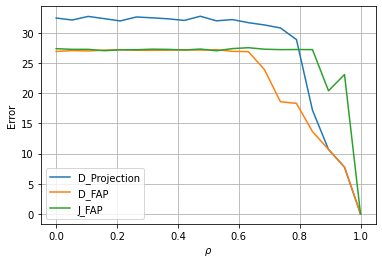

In [21]:


plt.plot(ro, D_pro_error_list,label="D_Projection")
plt.plot(ro, D_fap_error_list, label="D_FAP")
plt.plot(ro, J_fap_error_list, label="J_FAP")
plt.xlabel(r'$\rho$')
plt.ylabel('Error')
plt.grid()
plt.legend()
#plt.show()
#plt.close()
plt.savefig('Error of the three.eps', dpi=500)




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


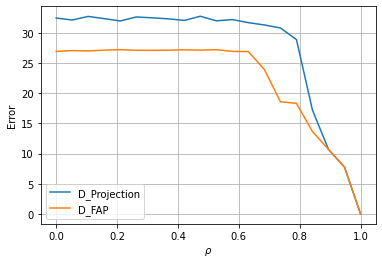

In [22]:
plt.plot(ro, D_pro_error_list,label="D_Projection")
plt.plot(ro, D_fap_error_list, label="D_FAP")

plt.xlabel(r'$\rho$')
plt.ylabel('Error')
plt.grid()
plt.legend()
#plt.show()
#plt.close()
plt.savefig('Whether FAP gives better perfromance (Error).eps', dpi=500)
